In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import numpy as np

import keras
import tensorflow as tf 
from keras.layers import Conv2D, Dense
from keras.layers import concatenate, add
from keras.layers import BatchNormalization, Activation, PReLU
from keras.layers import Input, Flatten, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from shutil import rmtree

from batch_generator import COCOBatchGenerator
from bsd100_callback import BSD100_Evaluator
from utils import print_available_devices, deprocess_HR, deprocess_LR

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
if tf.test.is_built_with_cuda():
    data_format = 'channels_first'
    keras.backend.set_image_data_format('channels_first')
else:
    data_format = 'channels_last'
    keras.backend.set_image_data_format('channels_last')

In [4]:
print("Keras : ", keras.__version__)
print("\t data_format : ", keras.backend.image_data_format())
print("Tensorflow : ", tf.__version__)
print_available_devices()

Keras :  2.1.6
	 data_format :  channels_first
Tensorflow :  1.8.0
Device : /device:CPU:0
	 type : CPU
	 desc :

Device : /device:GPU:0
	 type : GPU
	 desc :device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1



## Parameters

In [5]:
B = 16 # number of residual block

batch_size = 16
target_size = (96, 96)
downscale_factor = 4

num_steps = 1e5
steps_per_epoch = 5000
epochs = int(num_steps//steps_per_epoch)

# axis used in Parametric ReLU !
shared_axis = [1,2] if data_format == 'channels_last' else [2,3]

# axis for Batch Normalization
axis = -1 if data_format == 'channels_last' else 1
 
print('epochs = ', epochs)

epochs =  20


## Build the Generator

In [6]:
# build a residual block
def res_block(inputs):
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(inputs)
    x = BatchNormalization(axis=axis)(x)
    x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axis)(x)
    x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(x)
    x = BatchNormalization(axis=axis)(x)
    return add([x, inputs])

# build an upscale block
# PixelShuffler is replaced by an UpSampling2D layer (nearest upsampling)

def up_block(x):
    x = Conv2D(256, kernel_size=(3,3), strides=(1,1) , padding='same', activation=None, use_bias=False)(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=shared_axis)(x)
    return x

In [7]:
input_generator = Input(shape=(None, None, 3) if data_format=='channels_last' else (3, None, None), 
                        name='input_generator')

x = Conv2D(filters=64, kernel_size=(9,9),
           strides=(1,1), padding='same',
           activation=None)(input_generator)

x_input_res_block = PReLU(alpha_initializer='zeros',
                          alpha_regularizer=None,
                          alpha_constraint=None,
                          shared_axes=shared_axis)(x)

x = x_input_res_block

# add B residual blocks 
for i in range(B):
    x = res_block(x)

x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation=None, use_bias=False)(x)
x = BatchNormalization(axis=axis)(x)

# skip connection
x = add([x, x_input_res_block])

# two upscale blocks
x = up_block(x)
x = up_block(x)

# final conv layer : activated with tanh -> pixels in [-1, 1]
output_generator = Conv2D(3, kernel_size=(9,9), 
                          strides=(1,1), activation='tanh',
                          use_bias=False, padding='same')(x)

generator = Model(inputs=input_generator, outputs=output_generator)

In [8]:
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_generator (InputLayer)    (None, 3, None, None 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, None, Non 15616       input_generator[0][0]            
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 64, None, Non 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, None, Non 36864       p_re_lu_1[0][0]                  
__________________________________________________________________________________________________
batch_norm

In [9]:
# step loss and optimizer
opt = Adam(lr=1e-4, beta_1=0.9)
generator.compile(loss='mse', optimizer=opt)

## Training data

In [10]:
directory='data/COCO/train2014/'
batch_gen = COCOBatchGenerator(directory=directory,
                               batch_size=batch_size,
                               downscale_factor=4,
                               target_size=target_size,
                               shuffle=True,
                               crop_mode='fixed_size',
                               color_mode='rgb',
                               data_format=data_format)

Found 82783 images


(16, 3, 24, 24)
(16, 3, 96, 96)


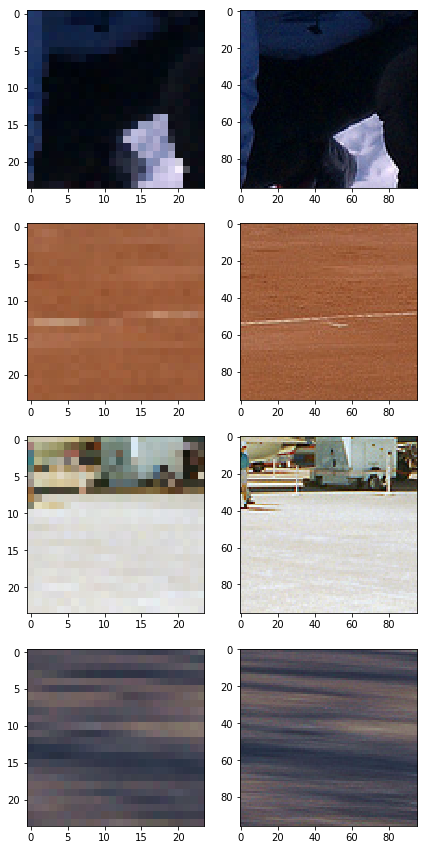

In [11]:
batch_LR, batch_HR = batch_gen.next()
print(batch_LR.shape)
print(batch_HR.shape)
if data_format == 'channels_first':
    batch_LR = np.transpose(batch_LR, (0,2,3,1))
    batch_HR = np.transpose(batch_HR, (0,2,3,1))

# LR| HR 
fig, axes = plt.subplots(4, 2, figsize=(7, 15))
for i in range(4):
    axes[i, 0].imshow(deprocess_LR(batch_LR[i]).astype(np.uint8))
    axes[i, 1].imshow(deprocess_HR(batch_HR[i]).astype(np.uint8))

## Train 'generator' with MSE Loss

In [12]:
if os.path.isdir('checkpoints/SRResNet-MSE/'):
    rmtree('checkpoints/SRResNet-MSE/')
os.mkdir('checkpoints/SRResNet-MSE/')

In [13]:
checkpoint = ModelCheckpoint(filepath='checkpoints/SRResNet-MSE/weights.{epoch:02d}-{loss:.2f}.hdf5',
                             monitor='loss',
                             save_weights_only=True,
                             period=10,
                             verbose=2)

best_checkpoint = ModelCheckpoint(filepath='checkpoints/SRResNet-MSE/best_weights.hdf5',
                                  monitor='loss',
                                  save_weights_only=True,
                                  save_best_only=True, 
                                  period=1,
                                  verbose=2)

bsd100_callback = BSD100_Evaluator(directory='data/BSD100/',
                                   filepath='checkpoints/SRResNet-MSE/BSD100/',
                                   downscale_factor=4,
                                   color_mode='rgb',
                                   verbose=1,
                                   data_format=data_format,
                                   margin=5)

early_stop = EarlyStopping(monitor='loss',min_delta=0, patience=3, verbose=1, mode='min')


callbacks = [checkpoint, best_checkpoint, bsd100_callback, early_stop]

Found 100 images ...


In [ ]:
%%time
history = generator.fit_generator(batch_gen,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  callbacks=callbacks)

Epoch 1/20
5000/5000 [==============================] - 1841s 368ms/step - loss: 0.0315

Epoch 00001: loss improved from inf to 0.03146, saving model to checkpoints/SRResNet-MSE/best_weights.hdf5

BSD100 Callback - Epoch 00001: MSE = 324.446  || PSNR = 24.0430257302  in 00013 s
Epoch 2/20
5000/5000 [==============================] - 2335s 467ms/step - loss: 0.0247

Epoch 00002: loss improved from 0.03146 to 0.02468, saving model to checkpoints/SRResNet-MSE/best_weights.hdf5

BSD100 Callback - Epoch 00002: MSE = 312.396  || PSNR = 24.2610239161  in 00023 s
Epoch 3/20
5000/5000 [==============================] - 2071s 414ms/step - loss: 0.0235

Epoch 00003: loss improved from 0.02468 to 0.02348, saving model to checkpoints/SRResNet-MSE/best_weights.hdf5

BSD100 Callback - Epoch 00003: MSE = 308.355  || PSNR = 24.3253422016  in 00014 s
Epoch 4/20
5000/5000 [==============================] - 1803s 361ms/step - loss: 0.0229

Epoch 00004: loss improved from 0.02348 to 0.02290, saving model t

In [ ]:
plt.figure(figsize=(16, 4))
plt.plot(history.history['loss'])
plt.title('training loss - COCO')
plt.ylabel('mse [-1, 1]')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(bsd100_callback.logs['mse'])
plt.title('validation loss - BSD100')
plt.ylabel('mse [0, 255]')
plt.xlabel('epoch')
plt.show()

plt.figure(figsize=(16, 4))
plt.plot(bsd100_callback.logs['psnr'])
plt.title('validation PSNR - BSD100')
plt.ylabel('PSNR (dB)')
plt.xlabel('epoch')
plt.show()